In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

import logging
from src.utils import setup_logging
setup_logging(console=True, file=True, debug=True, file_basename="k_sweep_BIG")
logger = logging.getLogger(__name__)

import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt

from src.plot import plot_predictive
from src.informed_np import InformedNeuralProcess
from tqdm import tqdm
# from src.loss import ELBOLoss
from src.loss import ELBOLoss
from src.train import train  

[INFO]: Logging setup completed at 14-08-2024-233603        (utils.py:62 [23:36:03])
/workspace/miniconda3/envs/pt2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def eval(model, data, use_knowledge=True, num_context=None):
    model.training = False
    with torch.no_grad():
        test_loss = 0
        n_test_batches = 128
        test_batch_size = 96
        for _ in range(n_test_batches):
            batch = data.generate_batch(batch_size=test_batch_size,
                                    device=DEVICE,
                                    return_knowledge=use_knowledge,
                                    split='test',
                                    num_context=num_context)

            p_y_pred, q_z_context, q_z_target = model(batch.x_context,
                                                  batch.y_context,
                                                  batch.x_target,
                                                  batch.y_target,
                                                  batch.knowledge)
            test_loss_dict = loss_function(p_y_pred, q_z_context, None, batch.y_target)
            test_loss += test_loss_dict["loss"].item() / n_test_batches
        # val_losses.append(val_loss)
        
    model.training = True
    print(f"Test Loss: {test_loss}, use_knowledge={use_knowledge}, num_context={num_context}")
    return test_loss

def k_and_nok_eval(model, data):
    k_test_losses = []
    nok_test_losses = []

    for num_context in range(1, 11):
        k_test_losses.append(eval(model, data, use_knowledge=True, num_context=num_context))
        nok_test_losses.append(eval(model, data, use_knowledge=False, num_context=num_context))

    return k_test_losses, nok_test_losses




In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f'Using DEVICE: {DEVICE}')

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

args = dict(
            x_dim=x_dim,
            y_dim=y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            determ_dim=determ_dim,
            knowledge_dim=128,
            mlps_activation=nn.GELU(),
            x_proj_dim=1,
            n_h_layers_x_proj=0,
            n_h_layers_decoder=4,
            n_h_layers_latent_xy_encoder=3,
            n_h_layers_film_latent_encoder=3,
            path='latent',
            train_num_z_samples=4,
            test_num_z_samples=32,
            use_bias=True,
            use_context_in_target=True, # TODO investigate
            use_latent_self_attn=True,
            # use_determ_self_attn=True,
            # use_determ_cross_attn=True,
            # use_knowledge=USE_KNOWLEDGE,
            # knowledge_dropout=0.3,
            roberta_return_cls=True,
            tune_llm_layer_norms=True,
            freeze_llm=True,
            knowledge_projection_n_h_layers=0,
            knowledge_aggregation_method='FiLM+MLP',
            device='cuda',
            beta=1.0
        )
assert "use_knowledge" not in args
assert "knowledge_dropout" not in args



AVG_LOSS_PRINT_INTERVAL = 250
PLOT_SAMPLE_INTERVAL = 1000
MAX_ITERS = 10000

LEARNING_RATE = 1e-3
loss_function = ELBOLoss(beta=1, reduction='mean')
random_states = [85, 98, 87]

MAX_NUM_CONTEXT = 10



[INFO]: Using DEVICE: cuda:0        (1959046854.py:2 [23:36:16])


In [18]:
#### NP ####
USE_KNOWLEDGE = False
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')

np_k_test_losses = np.zeros((len(random_states), MAX_NUM_CONTEXT))
np_nok_test_losses = np.zeros((len(random_states), MAX_NUM_CONTEXT))
for idx, random_state in enumerate(random_states):
    data = TempData(data=data_df , max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)

    np_model = InformedNeuralProcess(
        **args,
        use_knowledge=USE_KNOWLEDGE
    ).to(DEVICE)
    np_optimiser = torch.optim.Adam(np_model.parameters(), lr=LEARNING_RATE)
    
    np_model, best_np_model_path, optimiser, train_losses, val_losses = train(model=np_model,
                                                       data=data,
                                                       loss_function=loss_function,
                                                       optimiser=np_optimiser,
                                                       device=DEVICE,
                                                       use_knowledge=USE_KNOWLEDGE,
                                                       max_iters=MAX_ITERS,
                                                       avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                       plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                       model_save_name=f"sweep/np-kdropsweep-rs-{random_state}",
                                                                               verbose=False)
    np_model.load_state_dict(torch.load(best_np_model_path))
    k_test_losses, nok_test_losses = k_and_nok_eval(np_model, data)
    np_k_test_losses[idx] = k_test_losses
    np_nok_test_losses[idx] = nok_test_losses

print()
print(np_k_test_losses.mean(axis=0), np_k_test_losses.std(axis=0))
print(np_nok_test_losses.mean(axis=0), np_nok_test_losses.std(axis=0))





[INFO]: USE_KNOWLEDGE: False        (4055599156.py:3 [23:36:18])


NameError: name 'data_df' is not defined

In [ ]:
np.save("np_k_test_losses3.npy", np_k_test_losses) 
np.save("np_nok_test_losses3.npy", np_nok_test_losses) 

[INFO]: USE_KNOWLEDGE: True        (1585092657.py:3 [01:02:30])


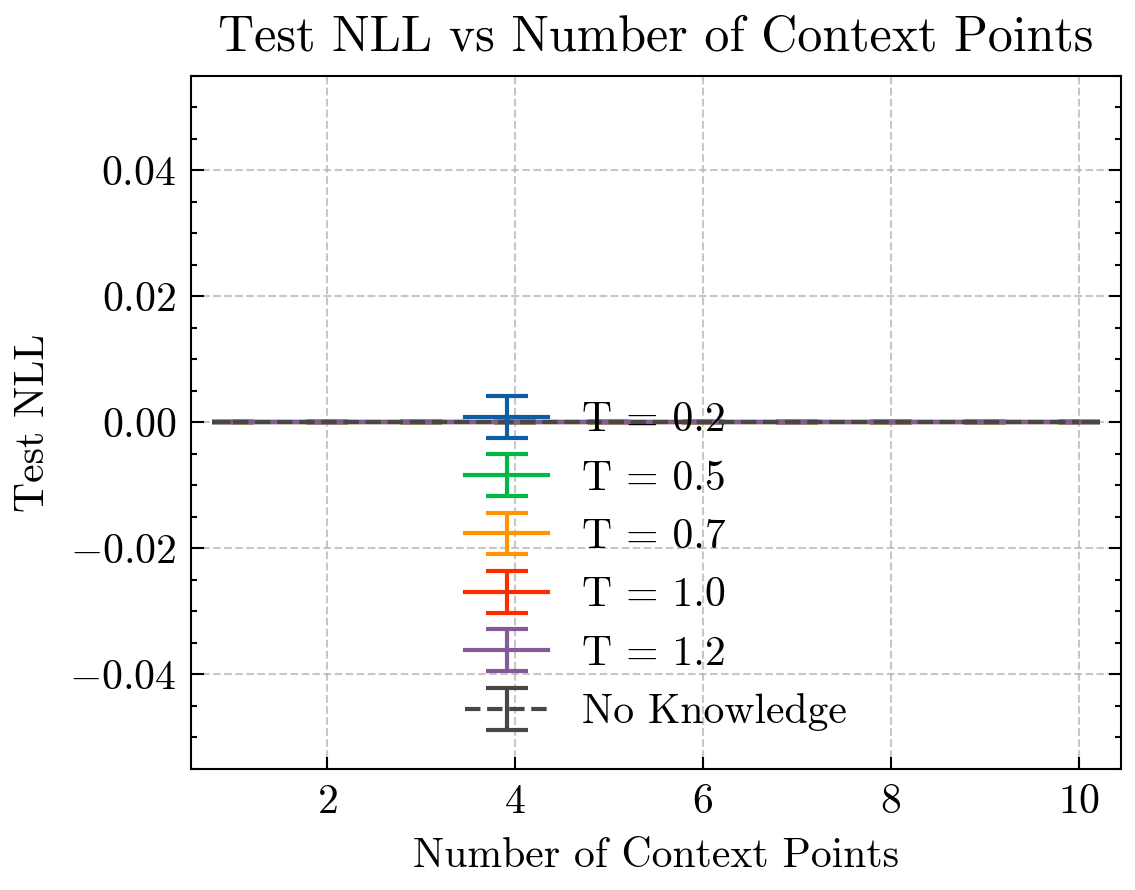

Figure saved as 'test_nll_vs_context_points.png'


In [53]:
#### INP ####
USE_KNOWLEDGE = True
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')
knowledge_dropout = 0.4
data_paths = ["../data/data_with_desc_temp_0.2.csv", "../data/data_with_desc_temp_0.5.csv",  "../data/data_with_desc_temp_0.7.csv", "../data/data_with_desc_temp_1.0.csv", "../data/data_with_desc_temp_1.2.csv"] 

inp_k_test_losses = np.zeros((len(data_paths), len(random_states), MAX_NUM_CONTEXT))
inp_nok_test_losses = np.zeros((len(data_paths), len(random_states), MAX_NUM_CONTEXT))

def extract_temp(path):
    filename = os.path.basename(path)
    match = re.search(r'temp_(\d+\.\d+)', filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Unable to extract temperature from filename: {filename}")

'''for sidx, data_path in enumerate(data_paths):
    
    data_df = pd.read_csv(data_path, header=None)
    data_df.columns = data_df.iloc[1]
    logging.info(f"Path {data_path}")

    print(data_path)
    print(data_df.head())
    
    for ridx, random_state in enumerate(random_states):
        data = TempData(data=data_df, max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)
        
        inp_model = InformedNeuralProcess(
            **args,
            knowledge_dropout=knowledge_dropout,
            use_knowledge=USE_KNOWLEDGE
        ).to(DEVICE)
        inp_optimiser = torch.optim.Adam(inp_model.parameters(), lr=LEARNING_RATE)
        
        inp_model, best_inp_model_path, optimiser, train_losses, val_losses = train(model=inp_model,
                                                           data=data,
                                                           loss_function=loss_function,
                                                           optimiser=inp_optimiser,
                                                           device=DEVICE,
                                                           use_knowledge=USE_KNOWLEDGE,
                                                           max_iters=MAX_ITERS,
                                                           avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                           plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                           model_save_name=f"sense/inp-sensesweep-{sidx}rs-{random_state}",
                                                                                   verbose=False)
        inp_model.load_state_dict(torch.load(best_inp_model_path))
        k_test_losses, nok_test_losses = k_and_nok_eval(inp_model, data)
        inp_k_test_losses[sidx, ridx] = k_test_losses
        inp_nok_test_losses[sidx, ridx] = nok_test_losses
        
        print()
    print(inp_k_test_losses[sidx].mean(axis=0), inp_k_test_losses[sidx].std(axis=0))
    print(inp_nok_test_losses[sidx].mean(axis=0), inp_nok_test_losses[sidx].std(axis=0))'''

plt.style.use('../figures/mplstyles/thesis.mplstyle')

for sidx, data_path in enumerate(data_paths):
    mean_k = inp_k_test_losses[sidx].mean(axis=0)
    std_k = inp_k_test_losses[sidx].std(axis=0)
    temp = extract_temp(data_path)
    plt.errorbar(range(1, MAX_NUM_CONTEXT+1), mean_k, yerr=std_k, 
                 label=f'T = {temp}', capsize=5)

# Plot for nok dataset
mean_nok = inp_nok_test_losses.mean(axis=(0, 1))
std_nok = inp_nok_test_losses.std(axis=(0, 1))
plt.errorbar(range(1, MAX_NUM_CONTEXT+1), mean_nok, yerr=std_nok, 
             label='No Knowledge', capsize=5, linestyle='--')

plt.xlabel('Number of Context Points')
plt.ylabel('Test NLL')
plt.title('Test NLL vs Number of Context Points')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure
plt.savefig('../figures/nonsense_test_nll_vs_context_points.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

print("Figure saved as 'test_nll_vs_context_points.png'")

[625.99942875 517.67840242 493.23790121 470.97030282 462.03885794
 457.87133622 452.44372725 451.423527   446.5977807  445.25417686]
[692.67268991 585.4274652  551.70336485 531.00628042 508.58672619
 507.74432826 505.0930953  498.72411966 493.5193069  489.29702497]
[760.27464342 715.06440878 673.34132767 659.08316088 662.23273802
 650.20618773 653.68645382 651.75859165 650.67438936 651.80543137]
[954.55905724 751.25272107 636.82154655 555.05618238 582.07929063
 521.31299543 504.51943827 484.22610068 484.04939342 487.9853785 ]
[778.92321014 703.35885    659.48835993 652.53902054 646.16871548
 634.9081521  623.67064238 621.43407917 622.58955431 612.86401892]
[983.17689896 772.99101334 688.82749424 635.11990719 617.18594551
 595.06508989 576.82374229 568.5323133  561.75540929 558.80214896]


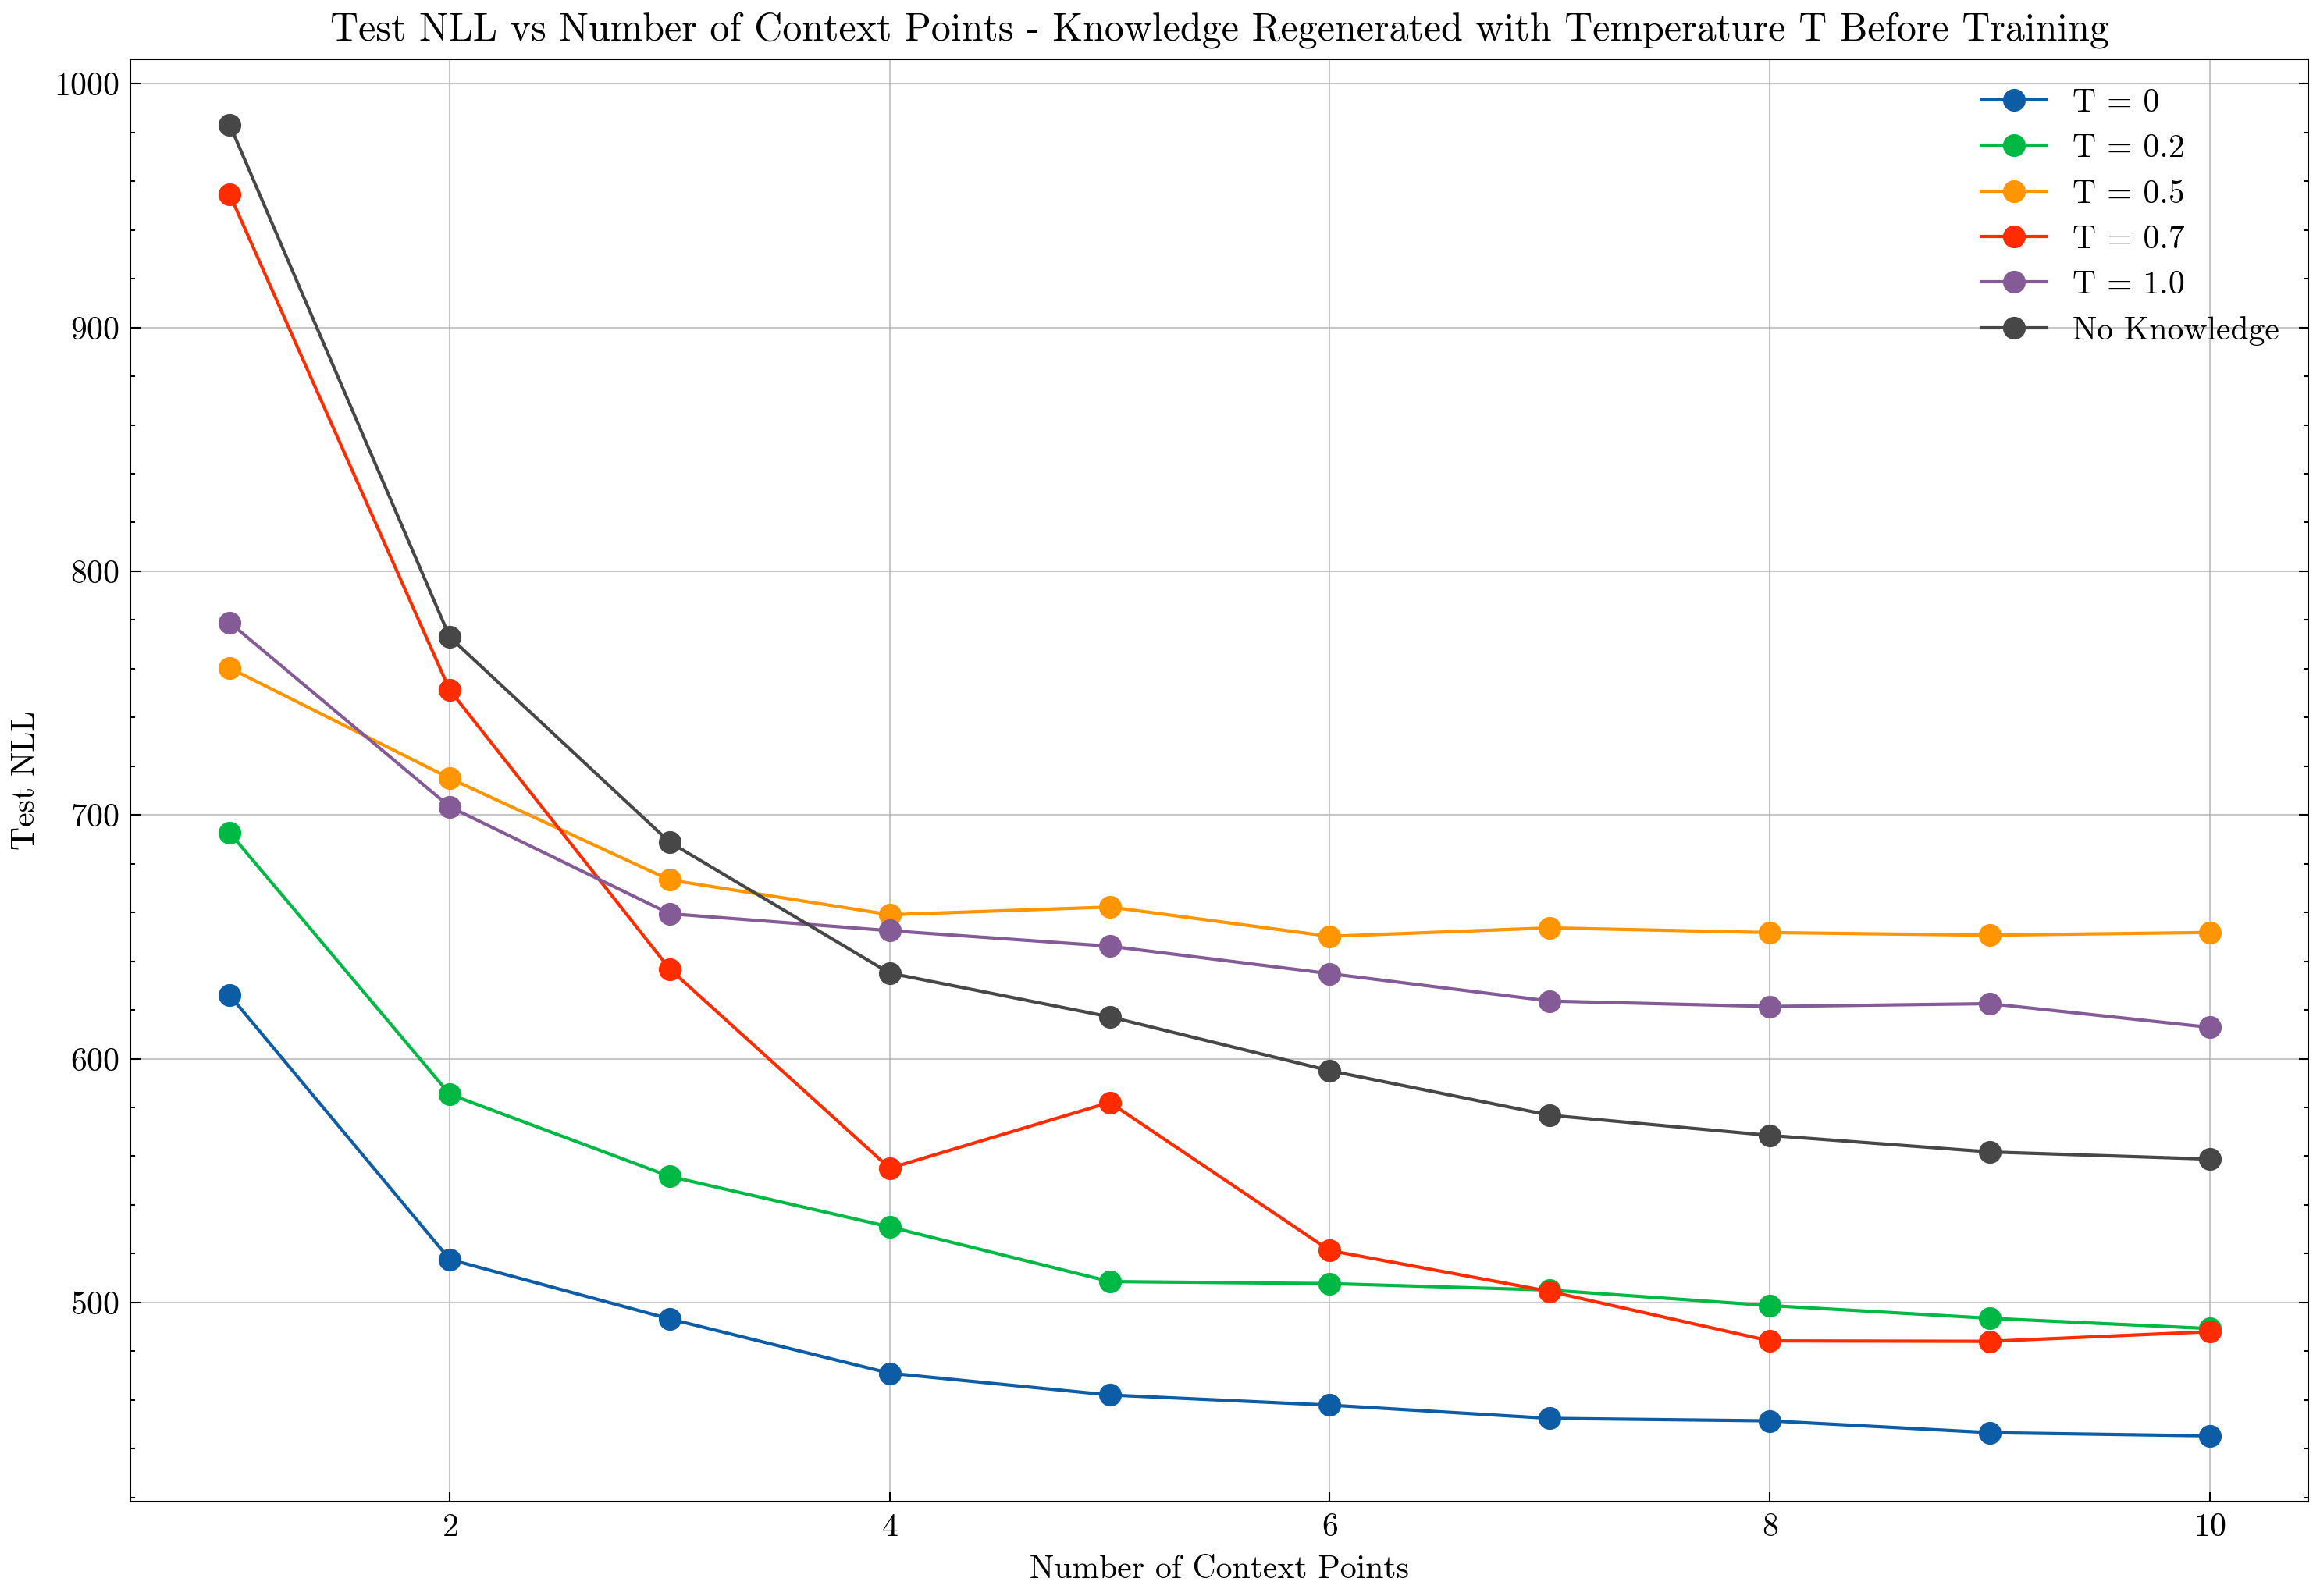

Figure saved as '../figures/nonsense_test_nll_vs_context_points.png'


In [61]:
'''import os
import re

plt.style.use('../figures/mplstyles/thesis.mplstyle')

USE_KNOWLEDGE = True
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')
data_paths = ["../data/data_with_desc.csv", "../data/data_with_desc_temp_0.2.csv", "../data/data_with_desc_temp_0.5.csv",  "../data/data_with_desc_temp_0.7.csv", "../data/data_with_desc_temp_1.0.csv"]
inp_k_test_losses = np.zeros((len(data_paths), len(random_states), MAX_NUM_CONTEXT))
inp_nok_test_losses = np.zeros((len(data_paths), len(random_states), MAX_NUM_CONTEXT))
random_states = [42]

def extract_temp(path):
    filename = os.path.basename(path)
    match = re.search(r'temp_(\d+\.\d+)', filename)
    if match:
        return match.group(1)
    else:
        return 0

def find_model_file(prefix):
    for file in os.listdir('../exp/sense'):
        if file.startswith(prefix):
            return os.path.join('../exp/sense', file)
    raise FileNotFoundError(f"No model file found with prefix {prefix}")

for sidx, data_path in enumerate(data_paths):
    data_df = pd.read_csv(data_path, header=None)
    data_df.columns = data_df.iloc[1]
    logging.info(f"Path {data_path}")
    print(data_path)
    
    for ridx, random_state in enumerate(random_states):
        data = TempData(data=data_df, max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)
        
        # Find and load the model
        model_prefix = f"inp-sensesweep-{sidx}rs-{random_state}"
        model_path = find_model_file(model_prefix)
        
        inp_model = InformedNeuralProcess(**args, knowledge_dropout=0.4, use_knowledge=USE_KNOWLEDGE).to(DEVICE)
        inp_model.load_state_dict(torch.load(model_path))
        
        # Evaluate on test set
        k_test_losses, nok_test_losses = k_and_nok_eval(inp_model, data)
        inp_k_test_losses[sidx, ridx] = k_test_losses
        inp_nok_test_losses[sidx, ridx] = nok_test_losses
        
    print(f"Knowledge Test Losses - Mean: {inp_k_test_losses[sidx].mean(axis=0)}, Std: {inp_k_test_losses[sidx].std(axis=0)}")
    print(f"No Knowledge Test Losses - Mean: {inp_nok_test_losses[sidx].mean(axis=0)}, Std: {inp_nok_test_losses[sidx].std(axis=0)}")'''

# Plotting
plt.figure(figsize=(12, 8))

for sidx, data_path in enumerate(data_paths):
    mean_k = inp_k_test_losses[sidx]
    print(mean_k.flatten())
    temp = extract_temp(data_path)
    plt.plot(range(1, MAX_NUM_CONTEXT+1), mean_k.flatten(), marker='o',
                 label=f'T = {temp}')

# Plot for nok dataset
mean_nok = inp_nok_test_losses.mean(axis=(0, 1))
print(mean_nok)
plt.plot(range(1, MAX_NUM_CONTEXT+1), mean_nok, 
             marker='o', label='No Knowledge')

plt.xlabel('Number of Context Points')
plt.ylabel('Test NLL')
plt.title('Test NLL vs Number of Context Points - Knowledge Regenerated with Temperature T Before Training')
plt.legend()
plt.grid(True, alpha=0.7)

# Save the figure
plt.savefig('../figures/nonsense_test_nll_vs_context_points.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

print("Figure saved as '../figures/nonsense_test_nll_vs_context_points.png'")

In [12]:
import pandas as pd

data_df_og = pd.read_csv("../data/data_with_desc.csv", header=None)
data_df_point2 = pd.read_csv("../data/data_with_desc_temp_0.2.csv", header=None)
data_df_1point2 = pd.read_csv("../data/data_with_desc_temp_1.2.csv", header=None)

print(data_df_og.head())

print(data_df_og[2].iloc[13])
print('--')
print(data_df_point2[2].iloc[13])
print('--')
print(data_df_1point2[2].iloc[13])

        0         1                                                  2    \
0  LST_DATE  LST_DATE                                        description   
1  20210101  20210101  The night will start off very chilly at around...   
2  20210102  20210102  The night will start off cold with temperature...   
3  20210103  20210103  The night will start off cold at -16.4°C and g...   
4  20210104  20210104  The night will start bitterly cold with temper...   

    3     4     5     6     7     8     9    ...     281     282     283  \
0   0.0   5.0  10.0  15.0  20.0  25.0  30.0  ...  2310.0  2315.0  2320.0   
1  -5.9  -5.6  -5.2  -4.7  -4.8  -3.5  -4.3  ...    -7.1    -7.1    -7.4   
2  -8.4  -8.5  -8.8  -8.9  -9.1  -9.3  -9.2  ...   -16.4   -16.2   -16.1   
3 -16.4 -16.4 -16.4 -16.3 -16.3 -16.3 -16.5  ...   -18.4   -18.2   -18.1   
4 -18.1 -18.0 -17.8 -17.9 -17.9 -17.9 -17.9  ...    -7.7    -7.7    -7.7   

      284     285     286     287     288     289     290  
0  2325.0  2330.0  2335.0 

In [5]:
np.save("inp_k_test_losses-true.npy", inp_k_test_losses) 
np.save("inp_nok_test_losses-true.npy", inp_nok_test_losses) 

In [5]:
inp_k_test_losses_03 = np.load("../notebooks/inp_k_test_losses.npy")
inp_nok_test_losses_03 = np.load("../notebooks/inp_nok_test_losses.npy")


In [3]:
n = 3
np_k_test_losses = np.load(f"../notebooks/np_k_test_losses{n}.npy")
np_nok_test_losses = np.load(f"../notebooks/np_nok_test_losses{n}.npy")

inp_k_test_losses = np.load(f"../notebooks/inp_k_test_losses-true.npy")
inp_nok_test_losses = np.load(f"../notebooks/inp_nok_test_losses-true.npy")

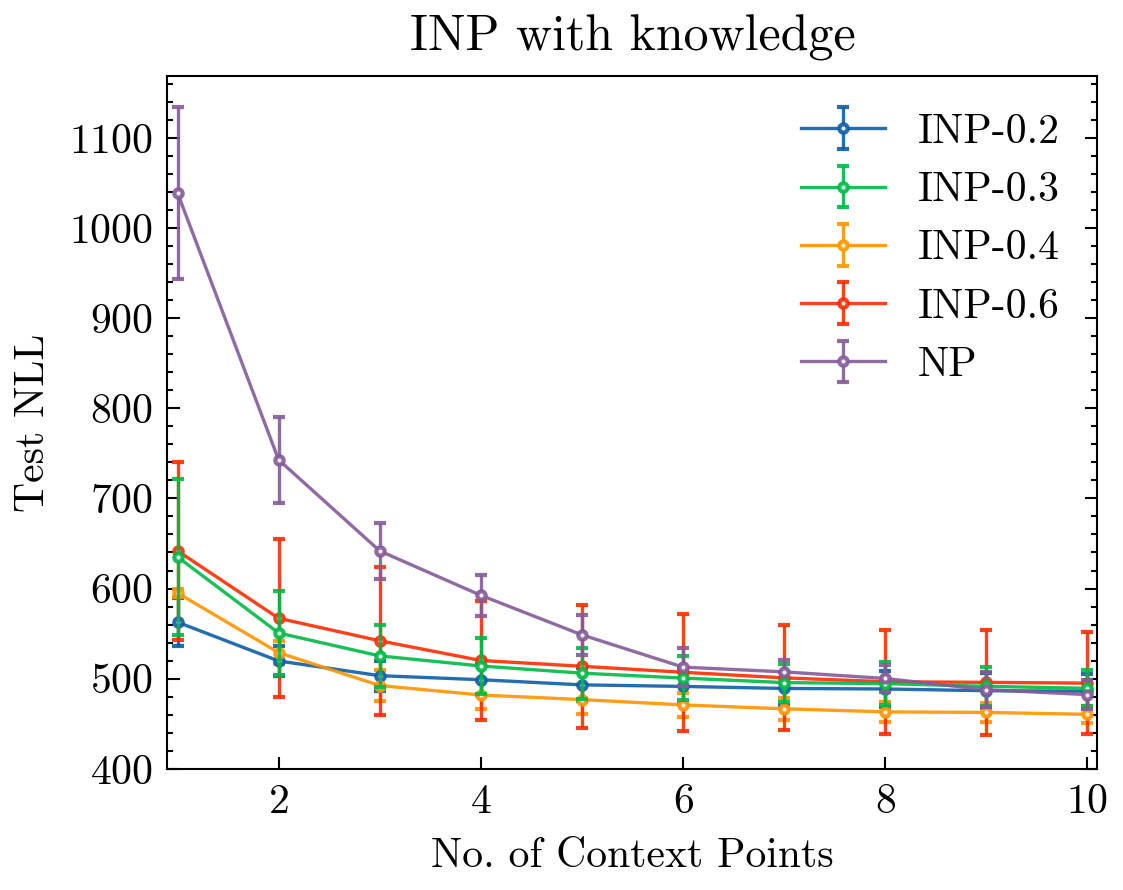

In [18]:
plt.style.use('../figures/mplstyles/thesis.mplstyle')

# Plot the data
# plt.figure(figsize=(10, 6))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
for i, k_dropout in enumerate([0.2, 0.4, 0.6]):
    if k_dropout == 0.4:
        plt.errorbar(num_context_points, 
             inp_k_test_losses_03[1].mean(axis=0), 
             yerr=inp_k_test_losses_03[1].std(axis=0), 
             capsize=1.5,  marker='o', markersize=2,  linestyle='-', linewidth=0.8,
              alpha=0.9, mfc='white',zorder=12, label="INP-0.3")
    
    plt.errorbar(num_context_points, 
                 inp_k_test_losses[i].mean(axis=0), 
                 yerr=inp_k_test_losses[i].std(axis=0), 
                 capsize=1.5,marker='o', linestyle='-', markersize=2, linewidth=0.8,
                 alpha=0.9, mfc='white',zorder=11, label=f"INP-{k_dropout}")

plt.errorbar(num_context_points, 
             np_k_test_losses.mean(axis=0), 
             yerr=np_k_test_losses.std(axis=0), 
             capsize=1.5,  marker='o', markersize=2,  linestyle='-', linewidth=0.8,
              alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of Context Points')
plt.ylabel('Test NLL')
plt.title("INP with knowledge")
plt.legend()
plt.xlim(0.9, 10.1)
plt.ylim(400,)
# plt.grid()
plt.savefig(f'../figures/knowledge-inp_vs_np_context_points-true.png', dpi=600)
plt.show()


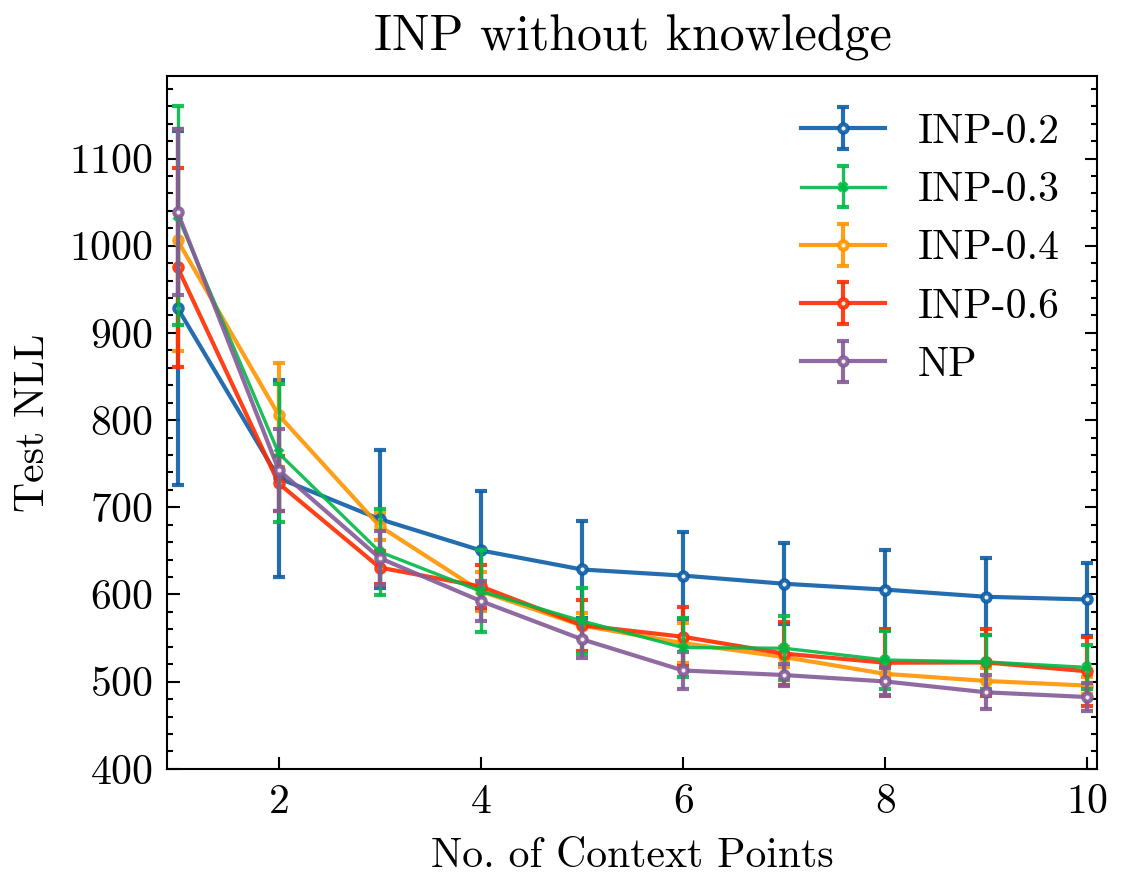

In [19]:
# Plot the data
# plt.figure(figsize=(10, 6))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
for i, k_dropout in enumerate([0.2, 0.4, 0.6]):
    if k_dropout == 0.4:
        plt.errorbar(num_context_points, 
             inp_nok_test_losses_03[1].mean(axis=0), 
             yerr=inp_nok_test_losses_03[1].std(axis=0), 
             capsize=1.5,  marker='x', markersize=2,  linestyle='-', linewidth=0.8,
              alpha=0.9, mfc='white',zorder=12, label="INP-0.3")

    plt.errorbar(num_context_points, 
                 inp_nok_test_losses[i].mean(axis=0), 
                 yerr=inp_nok_test_losses[i].std(axis=0), 
                 capsize=1.5,marker='o', markersize=2, alpha=0.9, mfc='white',zorder=11, label=f"INP-{k_dropout}")


plt.errorbar(num_context_points, 
             np_k_test_losses.mean(axis=0), 
             yerr=np_k_test_losses.std(axis=0), 
             capsize=1.5,  marker='o', markersize=2,  alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of Context Points')
plt.ylabel('Test NLL')
plt.title("INP without knowledge")
plt.legend()
np_k_test_losses
plt.xlim(0.9, 10.1)
plt.ylim(400,)
plt.savefig(f'../figures/noknowledge-inp_vs_np_context_points-true.png', dpi=600)
plt.show()
